In [142]:
from brian2 import *
import pandas as pd
import sympy
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import dh_parameters as dp

from scipy import optimize as op
%matplotlib notebook

from importlib import reload
reload(dp);

Some changes that need to happen: 

I need to be able to easily specify the inputs (spiking in afferents, current inj in neurons) and outputs (neuron group variables, probably spiking/vm) as matrices. I think I've basically done this now. 


I need to be able to easily specify which parameters are going to be free. Probably the easiest way to do this will be to make it possible to create a list of parameter names that are going to be free and a function that updates the network to change those parameters with each pass through a simulation. The question is whether or not to keep a nested structure for the parameter definitions; it might be easier if I could basically just have a vector. But to do that I'll need a better notation. Maybe it could be something like Parameter_neurongroup for intrinsic properties, and parameter_(pre,post) for synaptic properties. E.g. $p_{(Pep1,Vertical)}$

So one way would be to make it so I can linearize everything into this notation to specify the model, then use a subset of that list to say what is free.

Actually thinking about this more, that's a huge pain in the ass and not worth it. I should keep the parameters as tables 
- Intrinsics = one table of Neuron_types x Parameters
- Synaptic = N tables of Pre x Post for N different kinds of synaptic parameters

In [144]:
nts = [dp.neuron_types()[i] for i in [0,2,11]]
Ns = dp.get_N(nts)
intrinsics_df = dp.intrinsics_table_w_units()
p, w_mu, w_sigma, g_type = dp.interneuronal_connectivity_tables()

{'E_l': -60. * mvolt,
 'E_e': 0. * volt,
 'E_i': -70. * mvolt,
 'C_m': 40. * pfarad,
 'V_th': -40. * mvolt,
 'V_r': -60. * mvolt,
 'tau_e': 2. * msecond,
 'tau_i': 5. * msecond,
 'tau_r': 1. * msecond,
 'g_l_mu': 2. * nsiemens,
 'g_l_sigma': 250. * psiemens,
 'I_ex_mu': 0. * amp,
 'I_ex_sigma': 0. * amp,
 'b': 5. * pamp,
 'alpha': 200. * psiemens,
 'Delta_T': 1. * mvolt,
 'tau_u': 150. * msecond}

In [153]:
ngs = {}
for i,nt in enumerate(nts):
    ng = adex_group(N = Ns[i])
    ng.set_intrinsics(dp.intrinsics_df_2_dict(df,nt))
    ng.name = nt
    ngs[nt] = ng


AttributeError: can't set attribute

'neurongroup_3'

In [132]:
x = eval(tempstr)

In [134]:
tg ={}
tg['test'] = x
tg

{'test': -60. * mvolt}

In [148]:
class adex_group(NeuronGroup):
    def __init__(self, N = 1):
        model = '''dv/dt = (Delta_T*g_l*exp((-V_th + v)/Delta_T)
                 + g_e*(E_e - v) + g_i*(E_i - v) + g_l*(E_l - v) - u + I_ex(t, i))/C_m : volt (unless refractory)
                 dg_e/dt = -g_e/tau_e : siemens
                 dg_i/dt = -g_i/tau_i : siemens
                 du/dt = (alpha*(-E_l + v) - u)/tau_u : amp
                 g_l : siemens (constant)'''
        reset_eq = '''v = V_r
        u += b'''
        threshold_eq = 'v > V_th'
        refractory_eq = 'tau_r'
        super().__init__(N = N, model = model,
                        reset = reset_eq,
                         threshold = threshold_eq,
                         refractory = refractory_eq,
                         method = 'euler')
        
    def reset_variables(self):
        self.g_i = '0 * nS'
        self.g_e = '0 * nS'
        self.v = self.namespace['E_l']  
        self.u = '0 * pA'
    
    def initialize_I_ex_array(self):
        tb = np.arange(0,duration,sim_dt)
        I_ex_mu = self.namespace['I_ex_mu']
        I_ex_sigma = self.namespace['I_ex_sigma']
        I_ex_template = (I_ex_mu + I_ex_sigma * randn(self.N))
        self.namespace['I_ex'] = TimedArray(np.tile(I_ex_template, (tb.shape[0],1)),sim_dt)
    
    def set_cell_type(self, cell_type):
        params = dp.get_neuron_params(cell_type)
        for key, value in params['intrinsics'].items():
            self.namespace[key] = value
            
        # constant parameters that vary between neurons in this group
        g_l_mu = params['intrinsics']['g_l_mu']
        g_l_sigma = params['intrinsics']['g_l_sigma']
        self.g_l = (g_l_mu + g_l_sigma * randn(self.N))
        self.reset_variables()
        
    def set_intrinsics(self,intrinsics):
        
        for key, value in intrinsics.items():
            self.namespace[key] = value
            
        # constant parameters that vary between neurons in this group
        g_l_mu = intrinsics['g_l_mu']
        g_l_sigma = intrinsics['g_l_sigma']
        self.g_l = (g_l_mu + g_l_sigma * randn(self.N))
        self.reset_variables()
        
        
class drg_group(SpikeGeneratorGroup):
    
    def __init__(self, N = 1):
        super.__init__(N = N,indices = [0], times = [9999*second])
        
    def select_cell_type(self, cell_type):
        self.params = dp.get_afferent_params(cell_type)
        
    def add_stim(self, stim_type, start_time,**kwargs):    
        if stim_type == 'electrical':
            sigma = self.params['stim_electrical_sigma']
            N = self.N
            rates = self.params['stim_electrical_rates']
            if not isinstance(rates, (list, tuple, np.ndarray)):
                rates = np.ones(N)*rates
            
            stim_response, time_bins = self.gaussian_psth(start_time + self.params['delay'], sigma)
            self.psth += stim_response
            spikes, ind = self.generate_population_spikes(self.psth,rates)
            self.set_spikes(ind,spikes)

            
    def gaussian_psth(mu = 0 * ms, sigma = 0 * ms):
            time_bins = np.arange(0,duration,sim_dt)
            mu_ = mu 
            sigma_ = sigma  
            psth = (1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (time_bins - mu)**2 / (2 * sigma**2)))
            psth = psth/sum(psth)
            return psth,time_bins

    def spikes_from_psth(psth):
        return np.random.binomial(1,psth)

    def generate_population_spikes(kernel,rates):
        spikes = []
        ind = []
        for i,r in enumerate(rates):
            this_spikes = np.where(spikes_from_psth(kernel*r))[0]
            this_ind = np.ones(this_spikes.shape) * i
            spikes.append(this_spikes)
            ind.append(this_ind)
        spikes = np.concatenate(spikes) *sim_dt
        ind = np.concatenate(ind).astype(int)
        return spikes, ind
    
def generate_periodic_spike_times(rate, start_time, stop_time):
    ###unitless but do it in seconds to make it easy
    duration = stop_time - start_time
    num_spikes = np.floor(duration * rate)
    true_duration = num_spikes / rate
    spike_times = np.linspace(start_time, start_time + true_duration, num_spikes)
    return spike_times

def connect_neuron_groups(pre_group, post_group,
                          conductance_name = 'e',
                          p = 1, 
                          w_mu = 1 * nS, 
                          w_sigma = 0.1 * nS):
    on_pre_equation = 'g_' + conductance_name + '_post += w'
    S = Synapses(pre_group, post_group,model = 'w : siemens',
                             on_pre = on_pre_equation)
    S.connect(p = p)
    S.w =  w_mu + w_sigma * randn(S.w.shape[0])
    S.w['w < 0 * nS'] = 0 * nS
    return S

In [11]:
prms = dp.get_neuron_params(dp.neuron_types()[5])
prms

{'intrinsics': {'E_l': -60. * mvolt,
  'E_e': 0. * volt,
  'E_i': -70. * mvolt,
  'C_m': 40. * pfarad,
  'V_th': -40. * mvolt,
  'V_r': -60. * mvolt,
  'tau_e': 2. * msecond,
  'tau_i': 5. * msecond,
  'tau_r': 1. * msecond,
  'g_l_mu': 2. * nsiemens,
  'g_l_sigma': 250. * psiemens,
  'I_ex_mu': 0. * amp,
  'I_ex_sigma': 0. * amp,
  'b': 5. * pamp,
  'alpha': 200. * psiemens,
  'Delta_T': 1. * mvolt,
  'tau_u': 150. * msecond,
  'tau_m': 20. * msecond},
 'dynamics': 'adex',
 'model_eq': dv/dt = (Delta_T*g_l*exp((-V_th + v)/Delta_T) + g_e*(E_e - v) + g_i*(E_i - v) + g_l*(E_l - v) - u + I_ex(t, i))/C_m : volt (unless refractory)
 dg_e/dt = -g_e/tau_e : siemens
 dg_i/dt = -g_i/tau_i : siemens
 du/dt = (alpha*(-E_l + v) - u)/tau_u : amp
 g_l : siemens (constant)
 ,
 'reset_eq': '\n\t\tv = V_r \n\t\tu += b\n\t\t',
 'threshold_eq': 'v > V_th',
 'refractory_eq': 'tau_r',
 'outputs': {'e_vertical': {'p': 0.15,
   'w_mu': 1. * nsiemens,
   'w_sigma': 100. * psiemens,
   'conductance_name': 'e'}

In [76]:
x = adex_group(N = 5)
x.set_cell_type('e_nts')
x.initialize_I_ex_array()

In [77]:
net2 = Network(x)

In [78]:
net2.run(duration)

INFO       No numerical integration method specified for group 'neurongroup_12', using method 'euler' (took 0.14s, trying other methods took 0.32s). [brian2.stateupdaters.base.method_choice]
WARNING    "i" is an internal variable of group "neurongroup_12", but also exists in the run namespace with the value 2. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


In [84]:
z = SpikeGeneratorGroup(9,indices = [0], times = [9999*second])

In [4]:
zz = drg_group(N = 5)

NameError: name 'drg_group' is not defined

In [31]:
ngs['e_nts'].namespace['E_l'] = -40*mV

In [32]:
ngs['e_nts'].namespace['E_l']

-40. * mvolt

In [7]:
################################################################################
# Model parameters
################################################################################
### General parameters
duration = 30*ms  # Total simulation time
sim_dt = 0.1*ms        # Integrator/sampling step
defaultclock.dt = sim_dt

In [8]:
af_cts = ['AB_ltmr']
af_ngs = {}
af_params = {}
ct ='AB_ltmr'
constructor = afferent_group()
constructor.select_cell_type(ct)
constructor.add_stim('electrical', start_time = 10 * ms)
constructor.params['outputs']['e_nts']['p'] = 1
constructor.params['outputs']['e_nts']['w_mu'] = 0.5 * nS
constructor.params['outputs']['e_nts']['w_sigma'] = 0.01 * nS
constructor.params['outputs']['e_tac2']['p'] = 1
constructor.params['outputs']['e_tac2']['w_mu'] = 0.5 * nS
constructor.params['outputs']['i_pv']['p'] = 1
constructor.params['outputs']['i_pv']['w_mu'] = 0.5 * nS
af_ngs[ct], af_params[ct] = constructor.generate_afferent_group()
af_params['AB_ltmr']

{'outputs': {'e_nts': {'p': 1,
   'w_mu': 0.5 * nsiemens,
   'w_sigma': 10. * psiemens,
   'conductance_name': 'e'},
  'e_tac2': {'p': 1,
   'w_mu': 0.5 * nsiemens,
   'w_sigma': 100. * psiemens,
   'conductance_name': 'e'},
  'i_pv': {'p': 1,
   'w_mu': 0.5 * nsiemens,
   'w_sigma': 100. * psiemens,
   'conductance_name': 'e'},
  'i_gal': {'p': 0.15,
   'w_mu': 1. * nsiemens,
   'w_sigma': 100. * psiemens,
   'conductance_name': 'e'}},
 'N': 40,
 'delay': 0. * second,
 'location': ['2iv', '3', '4'],
 'neurotransmitter': 'e',
 'stim_electrical_sigma': 2. * msecond,
 'stim_electrical_rates': 9}

In [13]:
af_cts = ['AB_ltmr']
af_ngs = {}
af_params = {}
for ct in af_cts:
    constructor = afferent_group()
    constructor.select_cell_type(ct)
    constructor.add_stim('electrical', start_time = 10 * ms)
    constructor.params['outputs']['e_nts']['p'] = 1
    constructor.params['outputs']['e_nts']['w_mu'] = 0.5 * nS
    constructor.params['outputs']['e_nts']['w_sigma'] = 0.01 * nS
    constructor.params['outputs']['e_tac2']['p'] = 1
    constructor.params['outputs']['e_tac2']['w_mu'] = 0.5 * nS
    constructor.params['outputs']['e_tac2']['w_sigma'] = 0.01 * nS
    constructor.params['outputs']['i_pv']['p'] = 1
    constructor.params['outputs']['i_pv']['w_mu'] = 0.5 * nS
    constructor.params['outputs']['i_pv']['w_sigma'] = 0.01 * nS
    af_ngs[ct], af_params[ct] = constructor.generate_afferent_group()

default_e = {'p':1,'w_mu':1*nS, 'w_sigma':0.01*nS, 'conductance_name':'e'}
default_i = {'p':1,'w_mu':1*nS, 'w_sigma':0.01*nS, 'conductance_name':'i'}

cts = ['e_nts','e_tac2','i_pv']
ngs = {}
params = {}
i_ex = {}

ct = 'e_nts'
constructor = neuron_group_constructor()
constructor.select_cell_type(ct)
constructor.params['N'] = 20
ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
params[ct]['outputs']['e_tac2'] = default_e.copy()
params[ct]['outputs']['e_tac2']['w_mu'] = 1 * nS
params[ct]['outputs']['e_nts'] = default_e.copy()
params[ct]['outputs']['e_nts']['w_mu'] = 1 * nS
params[ct]['outputs']['i_pv'] = default_e.copy()
params[ct]['outputs']['i_pv']['w_mu'] = 1 * nS

ct = 'e_tac2'
constructor = neuron_group_constructor()
constructor.select_cell_type(ct)
constructor.params['N'] = 20
ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
params[ct]['outputs']['e_tac2']= default_e.copy()
params[ct]['outputs']['e_tac2']['w_mu'] = 1 * nS
params[ct]['outputs']['e_nts']= default_e.copy()
params[ct]['outputs']['e_nts']['w_mu'] = 1 * nS
params[ct]['outputs']['i_pv'] = default_e.copy()
params[ct]['outputs']['i_pv']['w_mu'] = 1 * nS

ct = 'i_pv'
constructor = neuron_group_constructor()
constructor.select_cell_type(ct)
constructor.params['N'] = 20
ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
params[ct]['outputs']['e_tac2']= default_i.copy()
params[ct]['outputs']['e_tac2']['w_mu'] = 1 * nS
params[ct]['outputs']['e_nts']= default_i.copy()
params[ct]['outputs']['e_nts']['w_mu'] = 1 * nS
params[ct]['outputs']['i_pv'] = default_i.copy()
params[ct]['outputs']['i_pv']['w_mu'] = 1 * nS


spikes = {}
for cell_type in params:
    spikes[cell_type]= SpikeMonitor(ngs[cell_type], record=True)    

synapses=[]
for pre, outputs in params.items():
    for post in outputs['outputs']:
        if post in params.keys():
            synapses.append(connect_neuron_groups(ngs[pre], ngs[post],**outputs['outputs'][post]))

for pre, outputs in af_params.items():
    for post in outputs['outputs']:
        if post in params.keys():
                synapses.append(connect_neuron_groups(af_ngs[pre], ngs[post],**outputs['outputs'][post]))

for ct in cts:
    initialize_I_ex(ngs[ct], i_ex[ct])

net = Network(ngs,spikes,synapses,af_ngs)
net.store()


In [14]:
beta = np.array([1,1,1,1,1,1,5,0.3,0.3])
change_S_and_rerun(net, synapses, beta)

NameError: name 'change_S_and_rerun' is not defined

In [15]:
global beta_
global rates_
global cost_
beta_ = []
rates_ = []
cost_ = []

In [16]:
def change_S_and_rerun(net, synapses, beta):
    net.restore()
    for n,this_w in enumerate(beta):
        synapses[n].w = (this_w + 0.001 * randn(synapses[n].w.shape[0]))* nS
        synapses[n].w['w < 0 * nS'] = 0 * nS
    net.run(duration)

    rates = []
    for ct in cts:
        rates.append(spikes[ct].t.shape[0]/params[ct]['N'])
    rates = np.array(rates)
    return rates, spikes

def run_network_change_syn(x, net, synapses, target_rates):

    rates, spikes = change_S_and_rerun(net, synapses, x)
    cost = np.sum((rates-target_rates) **2)
    
    beta_.append(x)
    rates_.append(rates)
    cost_.append(cost)
    print(x, rates, cost)
    return cost

In [17]:


def run_3_pop_w_ext_input(beta):
    af_cts = ['AB_ltmr']
    af_ngs = {}
    af_params = {}
    for ct in af_cts:
        constructor = afferent_group()
        constructor.select_cell_type(ct)
        constructor.add_stim('electrical', start_time = 10 * ms)
        constructor.params['outputs']['e_nts']['p'] = 1
        constructor.params['outputs']['e_nts']['w_mu'] = 0.5 * nS
        constructor.params['outputs']['e_nts']['w_sigma'] = 0.01 * nS
        constructor.params['outputs']['e_tac2']['p'] = 1
        constructor.params['outputs']['e_tac2']['w_mu'] = 0.5 * nS
        constructor.params['outputs']['e_tac2']['w_sigma'] = 0.01 * nS
        constructor.params['outputs']['i_pv']['p'] = 1
        constructor.params['outputs']['i_pv']['w_mu'] = 0.5 * nS
        constructor.params['outputs']['i_pv']['w_sigma'] = 0.01 * nS
        af_ngs[ct], af_params[ct] = constructor.generate_afferent_group()

    default_e = {'p':1,'w_mu':1*nS, 'w_sigma':0.01*nS, 'conductance_name':'e'}
    default_i = {'p':1,'w_mu':1*nS, 'w_sigma':0.01*nS, 'conductance_name':'i'}

    cts = ['e_nts','e_tac2','i_pv']
    ngs = {}
    params = {}
    i_ex = {}

    ct = 'e_nts'
    constructor = neuron_group_constructor()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 20
    ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
    params[ct]['outputs']['e_tac2'] = default_e.copy()
    params[ct]['outputs']['e_tac2']['w_mu'] = beta[0] * nS
    params[ct]['outputs']['e_nts'] = default_e.copy()
    params[ct]['outputs']['e_nts']['w_mu'] = beta[1] * nS
    params[ct]['outputs']['i_pv'] = default_e.copy()
    params[ct]['outputs']['i_pv']['w_mu'] = beta[2] * nS

    ct = 'e_tac2'
    constructor = neuron_group_constructor()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 20
    ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
    params[ct]['outputs']['e_tac2']= default_e.copy()
    params[ct]['outputs']['e_tac2']['w_mu'] = beta[3] * nS
    params[ct]['outputs']['e_nts']= default_e.copy()
    params[ct]['outputs']['e_nts']['w_mu'] = beta[4] * nS
    params[ct]['outputs']['i_pv'] = default_e.copy()
    params[ct]['outputs']['i_pv']['w_mu'] = beta[5] * nS

    ct = 'i_pv'
    constructor = neuron_group_constructor()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 20
    ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
    params[ct]['outputs']['e_tac2']= default_i.copy()
    params[ct]['outputs']['e_tac2']['w_mu'] = beta[6] * nS
    params[ct]['outputs']['e_nts']= default_i.copy()
    params[ct]['outputs']['e_nts']['w_mu'] = beta[7] * nS
    params[ct]['outputs']['i_pv'] = default_i.copy()
    params[ct]['outputs']['i_pv']['w_mu'] = beta[8] * nS

    
    spikes = {}
    for cell_type in params:
        spikes[cell_type]= SpikeMonitor(ngs[cell_type], record=True)    

    synapses=[]
    for pre, outputs in params.items():
        for post in outputs['outputs']:
            if post in params.keys():
                synapses.append(connect_neuron_groups(ngs[pre], ngs[post],**outputs['outputs'][post]))

    for pre, outputs in af_params.items():
        for post in outputs['outputs']:
            if post in params.keys():
                    synapses.append(connect_neuron_groups(af_ngs[pre], ngs[post],**outputs['outputs'][post]))

    for ct in cts:
        initialize_I_ex(ngs[ct], i_ex[ct])

    net = Network(ngs,spikes,synapses,af_ngs)
    net.run(duration)

    rates = []
    for ct in cts:
        rates.append(spikes[ct].t.shape[0]/params[ct]['N'])
    rates = np.array(rates)
    return rates, spikes

def run_network(beta, target_rates):
    rates, spikes = run_3_pop_w_ext_input(beta)
    cost = np.sum((rates-target_rates) **2)
    print(beta, cost)
    return cost

In [18]:
target_rates = np.array([15,5,16])
bounds = [(0.1,3),(0.1,3),(0.1,3),(0.1,3),(0.1,3),(0.1,3),(0.1,3),(0.1,3),(0.1,3)]
res = op.differential_evolution(func = run_network_change_syn,bounds = bounds,
                                args = [net, synapses, target_rates],polish = False,
                                maxiter = 20)

[1.98273873 2.68065684 2.84836112 2.85889388 1.85321082 0.19271597
 1.58139164 2.50417415 0.78407458] [22.1 22.  22. ] 375.41
[1.21296117 0.10462049 2.51316847 0.1541921  0.25857064 0.18378782
 0.3915564  0.22029905 0.9594104 ] [ 9.  7. 10.] 76.0
[0.49810645 1.27936503 1.50284466 1.69622186 0.78648433 2.94209507
 2.93044229 2.44105991 1.12932369] [2. 2. 6.] 278.0
[0.47526609 2.72637613 0.31083843 1.67563043 0.21737801 0.38666984
 2.335736   0.30213001 0.53049531] [6. 9. 7.] 178.0
[1.14417594 1.56591188 2.31666455 2.220795   2.01146014 2.70529755
 2.84526563 1.8413609  0.38178255] [ 6.  7. 10.] 121.0
[1.12676952 2.03560481 2.45897055 2.17752021 0.87906995 0.59781039
 0.78100558 0.75728387 2.98992319] [21. 21. 16.] 292.0
[2.18149265 2.19388783 0.78056721 1.63312131 0.1686252  0.10064623
 0.64307582 0.4485377  0.51342291] [21. 21. 15.] 293.0
[0.8689021  1.00531389 1.79531464 1.16836052 2.49118985 0.34921074
 2.9639748  0.12024779 2.06661577] [ 7.95 21.    9.  ] 354.7025
[1.0365486  1.1284

KeyboardInterrupt: 

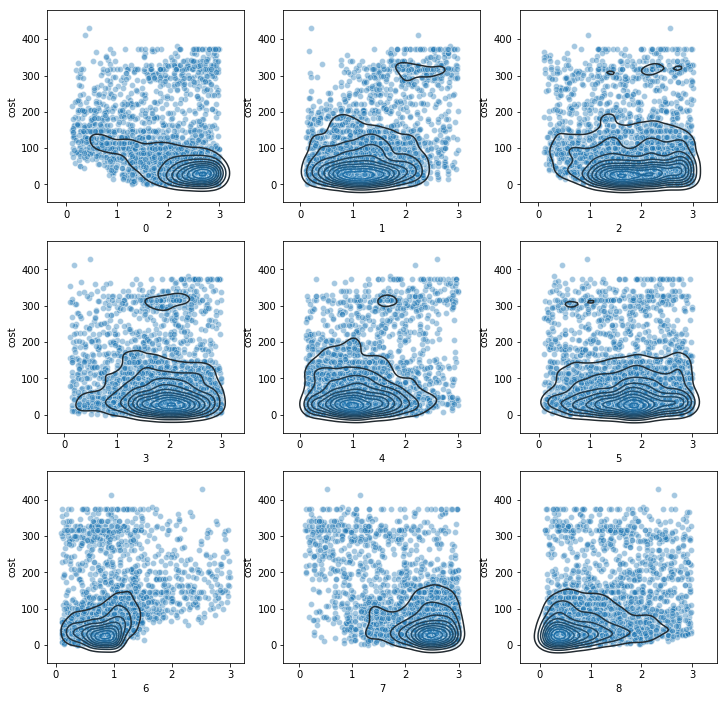

In [30]:
f,ax = plt.subplots(3,3,figsize = (12,12))
ax = ax.flatten()
for n in range(9):
    sns.kdeplot(df[n],df['cost'],ax = ax[n])
    sns.scatterplot(df[n],df['cost'],alpha = 0.4,ax = ax[n])

In [14]:
df = pd.DataFrame(np.stack(beta_))
df['cost'] = np.array(cost_)


,0,1,2,3,4,5,6,7,8,cost
0,0.823930,2.381083,1.038323,2.875637,2.375712,1.515974,1.493506,0.652964,1.939075,342.0000
1,2.284831,0.935385,1.377131,1.513695,2.243364,0.652130,0.461310,1.638905,2.453679,302.8900
2,1.538677,0.164640,2.810946,1.891562,0.334684,1.300336,0.198459,2.936650,0.262122,32.6025
3,1.908966,0.806269,2.052463,0.858984,1.697153,0.370800,0.369752,0.871965,0.879655,106.0000
4,2.190185,2.769527,0.622912,0.464326,2.828332,1.671758,0.599985,2.031123,0.536165,321.0000
5,2.266694,2.698507,1.943192,0.201585,2.908396,0.681297,0.773808,0.738206,2.351499,305.0000
6,2.341853,1.481093,1.846861,0.626249,1.376681,1.643781,2.074909,0.117163,2.077765,248.2850
7,2.768482,0.938564,2.028777,2.331981,2.561464,1.818618,2.120412,0.176568,0.972435,341.0000
8,0.865093,2.543461,2.981997,2.746036,1.827646,1.978885,0.678303,0.214907,2.429367,374.0000
9,1.132091,1.208565,2.786805,0.983728,0.439180,1.758592,2.501216,2.877916,1.003730,279.0025


In [19]:
beta_true = np.array([1.19, 0.68, 1.4, 1.5, 0.73, 2.96,
 0.38, 1.60, 2.18])
rates, spikes = run_3_pop_w_ext_input(beta_true)

In [ ]:

# net.add()
net.store()

In [ ]:
net.restore()

<IPython.core.display.Javascript object>


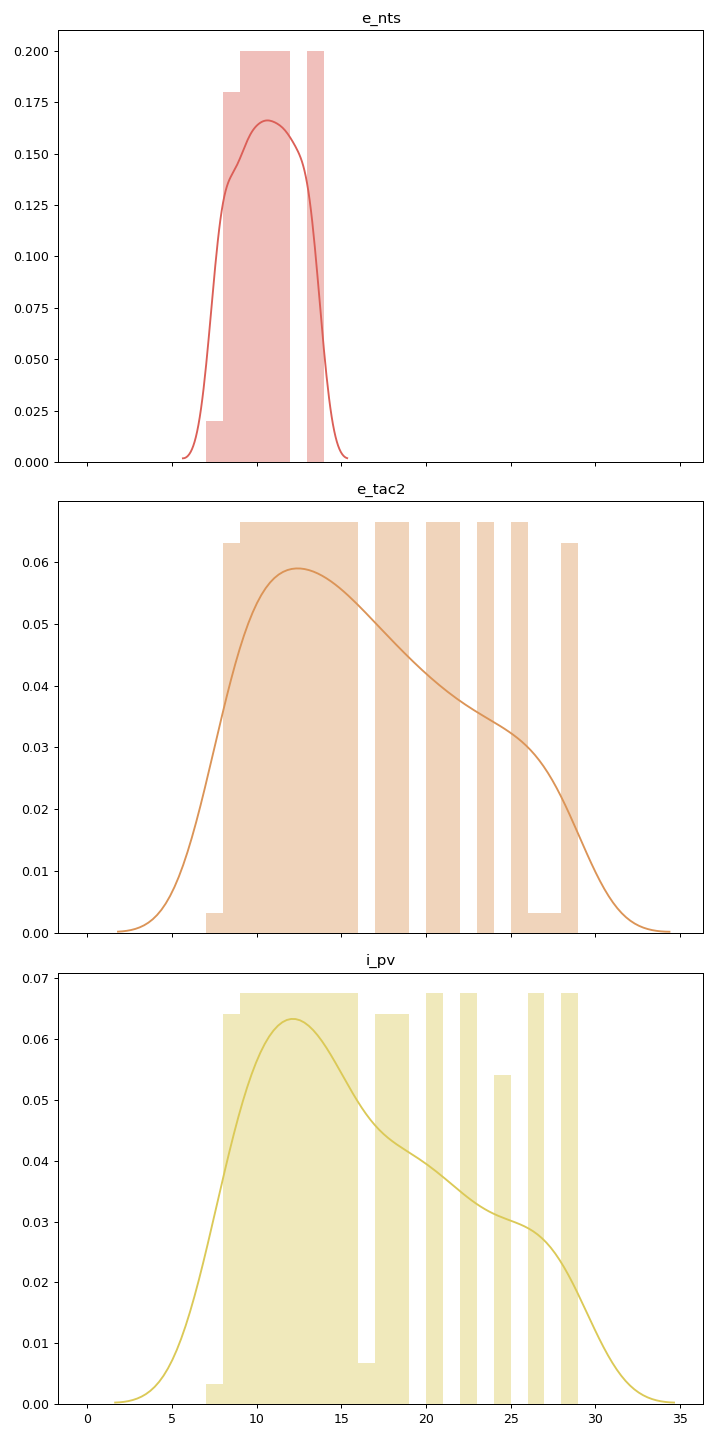

In [22]:
bins = np.arange(0,duration/ms,1)
cmap = sns.color_palette("hls", 15)
f,ax = plt.subplots(len(spikes),1,figsize = (8,16), sharex = True)
for i,(ct,spike_mon) in enumerate(spikes.items()):
    sns.distplot(spike_mon.t/ms, ax = ax[i], bins = bins, color = cmap[i])
    ax[i].set_title(ct)
plt.tight_layout()

In [ ]:
f,ax = plt.subplots(1,1,figsize = (8,8), sharex = True)
y_bias = 0
for i,(ct,spike_mon) in enumerate(spikes.items()):
    ax.plot(spike_mon.t/ms, spike_mon.i + y_bias,'.', color = cmap[i],alpha = 0.5);
    y_bias += params[ct]['N']
plt.tight_layout()

ax.set_ylim((ax.get_ylim()[-1],ax.get_ylim()[0]))

In [ ]:

ct = 'pep1'
constructor = afferent_group()
constructor.select_cell_type(ct)
constructor.params['N'] = 1
constructor.params['outputs']['i_gal']['p'] = 1
constructor.params['outputs']['i_gal']['w_mu'] = 7 * nS
constructor.add_spikes(indices = array([0]), spikes = array([5])* ms)
pre, pre_params = constructor.generate_afferent_group()


ct = 'i_gal'
ngs = {}
params = {}
i_ex = {}
constructor = neuron_group_constructor()
constructor.select_cell_type(ct)
constructor.params['N'] = 1
constructor.params['intrinsics']['g_l_sigma'] = 0.0001 * nS
constructor.params['intrinsics']['tau_e'] = 1 * ms
constructor.params['intrinsics']['E_l'] = -70 * mV
post, post_params, i_ex = constructor.generate_neuron_group()


states= StateMonitor(post, ['v','g_e','g_i'], record=True)
spikes= SpikeMonitor(pre, record=True)
    
syn = connect_neuron_groups(pre, post,**pre_params['outputs']['i_gal'])

initialize_I_ex(post, i_ex)

net = Network(post,states,spikes,syn,pre)  

net.store()

In [ ]:
net.run(duration, report = 'text',profile = True)

In [ ]:
f,ax = plt.subplots(1,1,figsize = (8,8))
ax.plot(states.t/ms, states.v_[0,:]/ms);
ax.plot(tb/ms,train_v/ms)
plt.xlim((5,20))

In [ ]:
x = [7.1351391, 14.7825336, 2.29645621, 2.4902152]
ct = 'pep1'
constructor = afferent_group()
constructor.select_cell_type(ct)
constructor.params['N'] = 1
constructor.params['outputs']['i_gal']['p'] = 1
constructor.params['outputs']['i_gal']['w_mu'] = x[0] * nS
constructor.add_spikes(indices = array([0]), spikes = array([x[1]])* ms)
pre, pre_params = constructor.generate_afferent_group()
ct = 'i_gal'
ngs = {}
params = {}
i_ex = {}
constructor = neuron_group_constructor()
constructor.select_cell_type(ct)
constructor.params['N'] = 1
constructor.params['intrinsics']['g_l_sigma'] = 0.0001 * nS
constructor.params['intrinsics']['g_l_mu'] = x[2] * nS
constructor.params['intrinsics']['tau_e'] = x[3] * ms
constructor.params['intrinsics']['E_l'] = -70 * mV
post, post_params, i_ex = constructor.generate_neuron_group()

states= StateMonitor(post, ['v','g_e','g_i'], record=True)
spikes= SpikeMonitor(pre, record=True)
syn = connect_neuron_groups(pre, post,**pre_params['outputs']['i_gal'])

initialize_I_ex(post, i_ex)

net = Network(post,states,spikes,syn,pre)
net.run(duration)
fit_v = states.v_[0].copy()

In [ ]:
f,ax = plt.subplots(1,1,figsize = (8,8))
ax.plot(states.t/ms, states.v_[0,:]/ms);
ax.plot(tb/ms,train_v/ms)
# plt.xlim((5,20))

In [ ]:
from scipy import optimize as op
def run_network(x, train_v):
    print(x)
    ct = 'pep1'
    constructor = afferent_group()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 1
    constructor.params['outputs']['i_gal']['p'] = 1
    constructor.params['outputs']['i_gal']['w_mu'] = x[0] * nS
    constructor.add_spikes(indices = array([0]), spikes = array([x[1]])* ms)
    pre, pre_params = constructor.generate_afferent_group()
    ct = 'i_gal'
    ngs = {}
    params = {}
    i_ex = {}
    constructor = neuron_group_constructor()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 1
    constructor.params['intrinsics']['g_l_sigma'] = 0.0001 * nS
    constructor.params['intrinsics']['g_l_mu'] = x[2] * nS
    constructor.params['intrinsics']['tau_e'] = x[3] * ms
    constructor.params['intrinsics']['E_l'] = -70 * mV
    post, post_params, i_ex = constructor.generate_neuron_group()

    states= StateMonitor(post, ['v','g_e','g_i'], record=True)
    spikes= SpikeMonitor(pre, record=True)
    syn = connect_neuron_groups(pre, post,**pre_params['outputs']['i_gal'])

    initialize_I_ex(post, i_ex)

    net = Network(post,states,spikes,syn,pre)
    net.run(duration)
    fit_v = states.v_[0].copy()
    cost = np.sum((fit_v -train_v) **2)
    print(x, cost)
    return cost

In [ ]:
bounds = [(0.1,30),(13,20),(0.5,5),(0.1,10)]
res = op.differential_evolution(func = run_network,bounds = bounds,
                                args = [train_v],
                                maxiter = 30)

In [ ]:
train_v = states.v_[0]

In [ ]:
from scipy import optimize as op
def run_network(x, train_v):
    
  
    print(x)
    ct = 'pep1'
    constructor = afferent_group()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 1
    constructor.params['outputs']['i_gal']['p'] = 1
    constructor.params['outputs']['i_gal']['w_mu'] = x[0] * nS
    constructor.params['outputs']['i_gal']['w_sigma'] = 0.0001 * nS
    constructor.add_spikes(indices = array([0]), spikes = array([x[1]])* ms)
    af_ngs[ct], af_params[ct] = constructor.generate_afferent_group()

    cts = ['i_gal']
    ngs = {}
    params = {}
    i_ex = {}
    for ct in cts:
        constructor = neuron_group_constructor()
        constructor.select_cell_type(ct)
        constructor.params['N'] = 1
        constructor.params['intrinsics']['g_l_sigma'] = 0.0001 * nS
        constructor.params['intrinsics']['tau_e'] = x[2] * ms
        ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()

    states={}
    spikes = {}
    for cell_type in params:
        states[cell_type]= StateMonitor(ngs[cell_type], ['v','g_e','g_i'], record=True)
        spikes[cell_type]= SpikeMonitor(ngs[cell_type], record=True)

    synapses=[]

    for pre, outputs in af_params.items():
        for post in outputs['outputs']:
            if post in params.keys():
                    print(pre,post)
                    synapses.append(connect_neuron_groups(af_ngs[pre], ngs[post],**outputs['outputs'][post]))

    for ct in cts:
        initialize_I_ex(ngs[ct], i_ex[ct])

    net = Network(ngs,states,spikes,synapses,af_ngs)
    net.run(duration)
    fit_v = states['i_gal'].v_[0].copy()
    return np.sum((fit_v -train_v) **2)


In [ ]:
bounds = [(0,50),(0.1,10),(0.1,10)]
res = op.differential_evolution(func = run_network,bounds = bounds,
                                args = [train_v],
                                maxiter = 30)

In [ ]:
res

In [ ]:
cmap = sns.color_palette("hls", 15)
f,ax = plt.subplots(len(spikes),1,figsize = (8,16), sharex = True)
for n,(ct,spike_mon) in enumerate(spikes.items()):
    sns.distplot(spike_mon.t/ms, ax = ax[n], bins = bins, color = cmap[n])
    ax[n].set_title(ct)
plt.tight_layout()


In [ ]:
reversed(ax.get_ylim())

In [ ]:
f,ax = plt.subplots(1,1,figsize = (8,8), sharex = True)
y_bias = 0
for i,(ct,spike_mon) in enumerate(spikes.items()):
    ax.plot(spike_mon.t/ms, spike_mon.i + y_bias,'.', color = cmap[i],alpha = 0.1);
    y_bias += params[ct]['N']
plt.tight_layout()

ax.set_ylim((ax.get_ylim()[-1],ax.get_ylim()[0]))

In [ ]:
f,ax = plt.subplots(len(spikes),1,figsize = (8,20), sharex = True)
for i,(ct,spike_mon) in enumerate(spikes.items()):
    ax[i].plot(spike_mon.t/ms, spike_mon.i,'.', color = cmap[i],alpha = 0.1);
    ax[i].set_title(ct)
plt.tight_layout()

In [ ]:
state_mon.v_.shape

In [ ]:
def make_spikes_pretty(spikemon,statemon,spike_height = 0.040):
    inds = spikemon.i
    time_inds = spikemon.t/sim_dt
    time_inds = time_inds.astype(int)
    for i,t in zip(inds,time_inds):
        statemon.v_[i,t] = spike_height

In [ ]:
f,ax = plt.subplots(len(states),1,figsize = (8,16))
for i,(ct,state_mon) in enumerate(states.items()):
    make_spikes_pretty(spikes[ct],state_mon)
    ax[i].plot(state_mon.t/ms, state_mon.v[0,:]/ms);
    ax[i].set_title(ct)

In [ ]:
f,ax = plt.subplots(len(states),1,figsize = (8,8))
for i,(ct,state_mon) in enumerate(states.items()):
    ax[i].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);
    ax[i].set_title(ct)

In [ ]:
# afferent inputs
AB_psth,time_bins = gaussian_psth(mu = 10 * ms, sigma = 1 * ms)
AD_psth,time_bins = gaussian_psth(mu = 20 * ms, sigma = 2 * ms)
C_psth,time_bins = gaussian_psth(mu = 120 * ms, sigma = 20 * ms)

C_spikes, C_ind = generate_population_spikes(C_psth,np.ones(50)*2)
AB_spikes, AB_ind = generate_population_spikes(AB_psth,np.ones(10)*5)
AD_spikes, AD_ind = generate_population_spikes(AD_psth,np.ones(10)*5)
f, ax = plt.subplots(2,1,figsize = (8,8), sharex = True)
ax[0].plot(AB_spikes, AB_ind,'.k')
ax[0].plot(AD_spikes, AD_ind+10,'.b')
ax[0].plot(C_spikes, C_ind+20,'.r')
ax[1].plot(time_bins, AB_psth,'k')
ax[1].plot(time_bins, AD_psth,'b')
ax[1].plot(time_bins, C_psth,'r')

In [ ]:
E_l = -70 * mV
E_e = 0 * mV
E_i = -70 * mV
C_m = 200 * pF
V_th = -40 * mV
V_r = -50 * mV
tau_e = 5 * ms
tau_i = 5 * ms
tau_r = 1 * ms
g_l = 0.5 * nS
I_ex = 20 * pA

In [ ]:
# neuron_eqs = Equations('''
# dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) + g_i*(E_i-v) +
#          I_ex)/C_m    : volt (unless refractory)
# dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
# dg_i/dt = -g_i/tau_i  : siemens  # post-synaptic exc. conductance
# g_l : siemens (constant)
# E_l : volt (constant)
# E_e : volt (constant)
# E_i : volt (constant)
# I_ex : amp
# C_m : farad (constant)
# tau_i : second (constant)
# tau_e : second (constant)
# ''')

neuron_eqs = Equations('''
dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) + g_i*(E_i-v) +
         I_ex)/C_m    : volt (unless refractory)
dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
dg_i/dt = -g_i/tau_i  : siemens  # post-synaptic exc. conductance
I_ex : amp (constant)
g_l : siemens (constant)
''')

# neuron_eqs = '''
# dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) + g_i*(E_i-v) +
#          I_ex)/C_m    : volt (unless refractory)
# dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
# dg_i/dt = -g_i/tau_i  : siemens  # post-synaptic exc. conductance
# '''



synapses_eqs = Equations('''
Omega_f : 1/second
Omega_d : 1/second
# Usage of releasable neurotransmitter per single action potential:
du_S/dt = -Omega_f * u_S     : 1 (event-driven)
# Fraction of synaptic neurotransmitter resources available:
dx_S/dt = Omega_d *(1 - x_S) : 1 (event-driven)
''')
synapses_action = '''
u_S += U_0 * (1 - u_S)
r_S = u_S * x_S
x_S -= r_S
'''

# maybe could switch to system where each synapse has a reversal potential
# rather than being excitatory vs inhibitory
# using (summed) 

In [ ]:
# NG = NeuronGroup(2, model=neuron_eqs,
#                  threshold='v>V_th',
#                  reset='v=V_r',
#                  refractory='tau_r',
#                  method = 'euler')
params = gen_default_params()
NG = NeuronGroup(2, model=neuron_eqs,
                 threshold='v>V_th',
                 reset='v=V_r',
                 refractory='tau_r',
                 method = 'euler')
for key, value in params.items():
    NG.namespace[key] = value

NG.g_i = '0 * nS'
NG.g_e = '0 * nS'
NG.v = '-70 * mV '
NG.namespace['I_ex'] = params['I_ex_mu'] + params['I_ex_sigma'] * randn(2)
# NG.I_ex = params['I_ex_mu'] + params['I_ex_sigma'] * randn(2)
# NG.I_ex = '(I_ex_mu + I_ex_sigma * randn())'
state_mon = StateMonitor(NG, ['v','I_ex','g_l'], record=True)

In [ ]:
I_ex = 

In [ ]:
NG.g_l = g_l
NG.E_l = E_l
NG.E_e = E_e
NG.E_i = E_i
NG.I_ex = I_ex
NG.C_m = C_m
NG.tau_i = tau_i
NG.tau_e = tau_e

In [ ]:
sub_G = NG[0:]
sub_G.namespace['I_ex'] = -50 * pA

In [ ]:
run(600 * ms)

In [ ]:
f,ax = plt.subplots(2,1,figsize = (8,8))
ax[0].plot(state_mon.t/ms, state_mon.v[0,:]/ms);
ax[0].plot(state_mon.t/ms, state_mon.v[1,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.I_ex[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.I_ex[1,:]/ms);
# ax[1].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);

In [ ]:
def gen_default_params():
    params = {}
    params['E_l'] = -70*mV           # Leak reversal potential
    params['E_e'] = 0*mV             # Excitatory synaptic reversal potential
    params['E_i'] = -70*mV           # Inhibitory synaptic reversal potential
    params['C_m'] = 200*pF           # Membrane capacitance
    params['V_th'] = -40*mV          # Firing threshold
    params['V_r'] = -60*mV           # Reset potential
    
    params['tau_e'] = 5*ms           # Excitatory synaptic time constant
    params['tau_i'] = 5*ms           # Inhibitory synaptic time constant
    params['tau_r'] = 1*ms           # Refractory period
    
    params['g_l_mu'] = 0.5 * nS
    params['g_l_sigma'] = 0.1 * nS
    
    params['I_ex_mu'] = 25 * pA
    params['I_ex_sigma'] = 20 * pA
    
    return params

In [ ]:
def gen_NG(N = 1,
           E_l = -70 * mV,
           E_e = 0 * mV,
           E_i = -70 * mV,
           C_m = 200 * pF,
           V_th = -40 * mV,
           V_r = -50 * mV,
           tau_e = 5 * ms,
           tau_i = 5 * ms,
           tau_r = 1 * ms,
           g_l_mu = 0.5 * nS,
           g_l_sigma = 0.1 * nS,
           I_ex_mu = 25 * pA,
           I_ex_sigma = 10 * pA,
           initialize = True):
    
    # constant parameters shared by all neurons in this group
    params['E_l'] = E_l 
    params['E_e'] = E_e 
    params['E_i'] = E_i 
    params['C_m'] = C_m 
    params['V_th'] = V_th 
    params['V_r'] = V_r
    params['tau_e'] = tau_e
    params['tau_i'] = tau_i
    params['tau_r'] = tau_r
    
    # constant parameters that vary between neurons in this group
    params['g_l'] = (g_l_mu + g_l_sigma * randn())
    
    params['I_ex'] = (I_ex_mu + I_ex_sigma * randn())

    
    NG = NeuronGroup(N, model=neuron_eqs,
                 threshold='v>V_th',
                 reset='v=V_r',
                 refractory='tau_r',
                 method = 'euler')
    
    for key, value in params.items():
        NG.namespace[key] = value
    
    if initialize:
        NG.g_i = '0 * nS'
        NG.g_e = '0 * nS'
        NG.v = E_l
    return NG

In [ ]:
# params = gen_default_params()
# NG = NeuronGroup(2, model=neuron_eqs,
#                  threshold='v>V_th',
#                  reset='v=V_r',
#                  refractory='tau_r',
#                  method = 'euler',
#                  namespace = params)
# P = PoissonGroup(10,50 * Hz)
# conn = Synapses(P,NG, model=synapses_eqs,
#                    on_pre=synapses_action+'g_e_post += w_e*r_S',delay = 20 * ms)


# NG = gen_NG(N = 2)
net = Network(NG)
state_mon = StateMonitor(NG, ['v'], record=True)



In [ ]:
run(duration)

In [ ]:
state_mon.get_states()

In [ ]:
net.run(duration, report='text')
f,ax = plt.subplots(2,1,figsize = (8,8))
ax[0].plot(state_mon.t/ms, state_mon.v[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_e[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);

In [ ]:
df = NG.get_states(units = False, format = 'pandas')
df

In [ ]:

N_NK1R = 10             # Number of NK1R
N_nNOS = 10
N_TRPV1 = 100

### Neuron parameters
E_l = -70*mV           # Leak reversal potential
g_l = 0.5*nS           # Leak conductance
E_e = 0*mV             # Excitatory synaptic reversal potential
E_i = -70*mV           # Excitatory synaptic reversal potential
C_m = 200*pF           # Membrane capacitance
tau_e = 5*ms           # Excitatory synaptic time constant
tau_i = 5*ms           # Excitatory synaptic time constant
tau_r = 5*ms           # Refractory period
I_ex = 0*pA            # External current
V_th = -40*mV          # Firing threshold
V_r = -60*mV           # Reset potential

### Synapse parameters
w_e = 1*nS          # Excitatory synaptic conductance
w_i = 3 * nS        # inhibitory synaptic conductance
U_0 = 0.1              # Synaptic release probability at rest
Omega_d = 10/second   # Synaptic depression rate
Omega_f = 0.1/second  # Synaptic facilitation rate

################################################################################
# Model definition
################################################################################
# Set the integration time (in this case not strictly necessary, since we are
# using the default value)
defaultclock.dt = sim_dt

### External inputs
# P = PoissonGroup(N_ext,10 * Hz)

indices = []
times = []
rate = 5 
start_time = 0.1
stop_time = 1.5
for i in range(N_TRPV1):
    this_times = generate_periodic_spike_times(rate, start_time, stop_time) * second
    times.append(this_times) 
    indices.append(np.ones(this_times.shape)*i)
    
TRPV1 = SpikeGeneratorGroup(N_TRPV1,times = np.concatenate(times) * second,
                        indices = np.concatenate(indices))


In [ ]:
### Neurons

neurons = NeuronGroup(N_NK1R + N_nNOS, model=neuron_eqs,
                      threshold='v>V_th', reset='v=V_r',
                      refractory='tau_r', method='euler')

# Random initial membrane potential values and conductances
# neurons.v = 'E_l + rand()*(V_th-E_l)'
# neurons.g_e = 'rand()*w_e'
neurons.v = 'E_l'
neurons.g_e = '0*w_e'
NK1R_neurons = neurons[:N_NK1R]
nNOS_neurons = neurons[N_NK1R:]

### Synapses
synapses_eqs = '''
Omega_f : 1/second
Omega_d : 1/second
# Usage of releasable neurotransmitter per single action potential:
du_S/dt = -Omega_f * u_S     : 1 (event-driven)
# Fraction of synaptic neurotransmitter resources available:
dx_S/dt = Omega_d *(1 - x_S) : 1 (event-driven)
'''
synapses_action = '''
u_S += U_0 * (1 - u_S)
r_S = u_S * x_S
x_S -= r_S
'''
TRPV1_to_NK1R = Synapses(TRPV1,NK1R_neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_e_post += w_e*r_S',delay = 20 * ms)
TRPV1_to_NK1R.connect(p=1)
TRPV1_to_NK1R.x_S = 1

TRPV1_to_nNOS = Synapses(TRPV1,nNOS_neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_e_post += w_e*r_S',delay = 20 * ms)
TRPV1_to_nNOS.connect(p=1)
TRPV1_to_nNOS.x_S = 1

nNOS_to_NK1R = Synapses(nNOS_neurons,NK1R_neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_i_post += w_i*r_S')
nNOS_to_NK1R.connect(p=1)
nNOS_to_NK1R.x_S = 1

# Start from "resting" condition: all synapses have fully-replenished
# neurotransmitter resources


# independent variable - changing the ratio of Omega_f to Omega_d
# exc_syn.Omega_f = np.logspace(-1,2,100) * Hz
# exc_syn.Omega_d = np.logspace(2,-1,100) * Hz


# ##############################################################################
# # Monitors
# ##############################################################################
# Note that we could use a single monitor for all neurons instead, but in this
# way plotting is a bit easier in the end
NK1R_mon = SpikeMonitor(NK1R_neurons)
nNOS_mon = SpikeMonitor(nNOS_neurons)
spike_mon = SpikeMonitor(neurons)

ext_mon = SpikeMonitor(TRPV1)
### We record some additional data from a single excitatory neuron
ni = 0
# Record conductances and membrane potential of neuron ni
state_mon = StateMonitor(NK1R_neurons, ['v', 'g_e','g_i'], record=True)
# We make sure to monitor synaptic variables after synapse are updated in order
# to use simple recurrence relations to reconstruct them. Record all synapses
# originating from neuron ni
# synapse_mon = StateMonitor(exc_syn, ['u_S', 'x_S'],
#                            record=exc_syn[:,ni], when='after_synapses')

In [ ]:
run(duration, report='text')
f,ax = plt.subplots(2,1,figsize = (8,8))
ax[0].plot(state_mon.t/ms, state_mon.v[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_e[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);

In [ ]:
f,ax = plt.subplots(2,1,figsize = (8,8))
ax[0].plot(state_mon.t/ms, state_mon.v[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_e[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);

In [ ]:
NK1R_mon.t

In [ ]:
f,ax = plt.subplots(figsize = (10,10))
ax.plot(spike_mon.t/ms, spike_mon.i,'.')

In [ ]:
f,ax = plt.subplots(2,1,figsize = (10,10))
ax[0].plot(state_mon.t/ms, state_mon.g_e[0,:]/ms);
ax[0].plot(state_mon.t/ms, state_mon.g_e[99,:]/ms);
ax[1].imshow(np.array(state_mon.g_e)*10**10,aspect = 'auto',vmin = 0, vmax = 0.5)

Now let's make the external inputs Poisson trains, from a population of 1000 neurons all firing at 10 Hz

In [ ]:

### General parameters
duration = 3*second  # Total simulation time
sim_dt = 0.1*ms        # Integrator/sampling step
N_e = 100             # Number of excitatory neurons
N_ext = 1000

### Neuron parameters
E_l = -60*mV           # Leak reversal potential
g_l = 100*nS         # Leak conductance
E_e = 0*mV             # Excitatory synaptic reversal potential
C_m = 200*pF           # Membrane capacitance
tau_e = 5*ms           # Excitatory synaptic time constant
tau_r = 5*ms           # Refractory period
I_ex = 0*pA            # External current
V_th = -50*mV          # Firing threshold
V_r = E_l              # Reset potential

### Synapse parameters
w_e = 0.05*nS          # Excitatory synaptic conductance
U_0 = 0.1              # Synaptic release probability at rest
# Omega_d = 10/second   # Synaptic depression rate
# Omega_f = 0.1/second  # Synaptic facilitation rate

################################################################################
# Model definition
################################################################################
# Set the integration time (in this case not strictly necessary, since we are
# using the default value)
defaultclock.dt = sim_dt

### External inputs
P = PoissonGroup(N_ext,20 * Hz)


### Neurons
neuron_eqs = '''
dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) +
         I_ex)/C_m    : volt (unless refractory)
dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
'''
neurons = NeuronGroup(N_e, model=neuron_eqs,
                      threshold='v>V_th', reset='v=V_r',
                      refractory='tau_r', method='euler')
# Random initial membrane potential values and conductances
# neurons.v = 'E_l + rand()*(V_th-E_l)'
# neurons.g_e = 'rand()*w_e'
neurons.v = 'E_l'
neurons.g_e = '0*w_e'
exc_neurons = neurons[:N_e]

### Synapses
synapses_eqs = '''
Omega_f : 1/second
Omega_d : 1/second
# Usage of releasable neurotransmitter per single action potential:
du_S/dt = -Omega_f * u_S     : 1 (event-driven)
# Fraction of synaptic neurotransmitter resources available:
dx_S/dt = Omega_d *(1 - x_S) : 1 (event-driven)
'''
synapses_action = '''
u_S += U_0 * (1 - u_S)
r_S = u_S * x_S
x_S -= r_S
'''
exc_syn = Synapses(P,exc_neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_e_post += w_e*r_S')

exc_syn.connect(p=1)
# Start from "resting" condition: all synapses have fully-replenished
# neurotransmitter resources
exc_syn.x_S = 1

# independent variable - changing the ratio of Omega_f to Omega_d
omega_fs = np.logspace(-1,2,100)
omega_ds = np.logspace(2,-1,100)

# exc_syn.Omega_f = np.array([f * np.ones(N_ext) for f in omega_fs]).flatten() * Hz
# exc_syn.Omega_d = np.array([d * np.ones(N_ext) for d in omega_ds]).flatten() * Hz

exc_syn.Omega_f = np.tile(omega_fs,1000) * Hz
exc_syn.Omega_d = np.tile(omega_ds,1000) * Hz


# ##############################################################################
# # Monitors
# ##############################################################################
# Note that we could use a single monitor for all neurons instead, but in this
# way plotting is a bit easier in the end
exc_mon = SpikeMonitor(exc_neurons)

ext_mon = SpikeMonitor(P)
### We record some additional data from a single excitatory neuron
ni = 0
# Record conductances and membrane potential of neuron ni
state_mon = StateMonitor(exc_neurons, ['v', 'g_e'], record=True)
# We make sure to monitor synaptic variables after synapse are updated in order
# to use simple recurrence relations to reconstruct them. Record all synapses
# originating from neuron ni
synapse_mon = StateMonitor(exc_syn, ['u_S', 'x_S'],
                           record=exc_syn[:,ni], when='after_synapses')

In [ ]:
run(duration, report='text')

In [ ]:
f,ax = plt.subplots(2,1,figsize = (10,10))
ax[0].plot(state_mon.t/ms, state_mon.g_e[0,:]/ms);
ax[0].plot(state_mon.t/ms, state_mon.g_e[99,:]/ms);
ax[1].imshow(np.array(state_mon.g_e)*10**9,aspect = 'auto',vmin = 0, vmax = 2)



Okay, now let's change the distribution of firing rates among the external inputs while keeping the total number of input spikes roughly the same

In [ ]:
df_agg = []
sigma_frs = [0.01,0.1,0.2,0.3,0.4,0.5,1,2]
for sigma_fr in sigma_frs:

    mu_fr = 70

    ### General parameters
    duration = 3*second  # Total simulation time
    sim_dt = 0.1*ms        # Integrator/sampling step
    N_e = 100             # Number of excitatory neurons
    N_ext = 1000

    ### Neuron parameters
    E_l = -60*mV           # Leak reversal potential
    g_l = 100*nS         # Leak conductance
    E_e = 0*mV             # Excitatory synaptic reversal potential
    C_m = 200*pF           # Membrane capacitance
    tau_e = 5*ms           # Excitatory synaptic time constant
    tau_r = 5*ms           # Refractory period
    I_ex = 0*pA            # External current
    V_th = -50*mV          # Firing threshold
    V_r = E_l              # Reset potential

    ### Synapse parameters
    w_e = 0.05*nS          # Excitatory synaptic conductance
    U_0 = 0.1              # Synaptic release probability at rest
    # Omega_d = 10/second   # Synaptic depression rate
    # Omega_f = 0.1/second  # Synaptic facilitation rate

    ################################################################################
    # Model definition
    ################################################################################
    # Set the integration time (in this case not strictly necessary, since we are
    # using the default value)
    defaultclock.dt = sim_dt


    ### Neurons
    neuron_eqs = '''
    dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) +
             I_ex)/C_m    : volt (unless refractory)
    dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
    '''
    neurons = NeuronGroup(N_e, model=neuron_eqs,
                          threshold='v>V_th', reset='v=V_r',
                          refractory='tau_r', method='euler')
    # Random initial membrane potential values and conductances
    # neurons.v = 'E_l + rand()*(V_th-E_l)'
    # neurons.g_e = 'rand()*w_e'
    neurons.v = 'E_l'
    neurons.g_e = '0*w_e'
    exc_neurons = neurons[:N_e]

    ### Synapses
    synapses_eqs = '''
    Omega_f : 1/second
    Omega_d : 1/second
    # Usage of releasable neurotransmitter per single action potential:
    du_S/dt = -Omega_f * u_S     : 1 (event-driven)
    # Fraction of synaptic neurotransmitter resources available:
    dx_S/dt = Omega_d *(1 - x_S) : 1 (event-driven)
    '''
    synapses_action = '''
    u_S += U_0 * (1 - u_S)
    r_S = u_S * x_S
    x_S -= r_S
    '''

    frs = np.random.lognormal(np.log(10),sigma_fr,N_ext)
    frs = frs * mu_fr / frs.mean()
    ### External inputs
    P = PoissonGroup(N_ext,frs * Hz)

    exc_syn = Synapses(P,exc_neurons, model=synapses_eqs,
                       on_pre=synapses_action+'g_e_post += w_e*r_S')

    exc_syn.connect(p=1)
    # Start from "resting" condition: all synapses have fully-replenished
    # neurotransmitter resources
    exc_syn.x_S = 1

    # independent variable - changing the ratio of Omega_f to Omega_d
    omega_fs = np.logspace(-2,2,100)
    omega_ds = np.logspace(2,-2,100)

    # exc_syn.Omega_f = np.array([f * np.ones(N_ext) for f in omega_fs]).flatten() * Hz
    # exc_syn.Omega_d = np.array([d * np.ones(N_ext) for d in omega_ds]).flatten() * Hz

    exc_syn.Omega_f = np.tile(omega_fs,1000) * Hz
    exc_syn.Omega_d = np.tile(omega_ds,1000) * Hz


    # ##############################################################################
    # # Monitors
    # ##############################################################################
    # Note that we could use a single monitor for all neurons instead, but in this
    # way plotting is a bit easier in the end
    exc_mon = SpikeMonitor(exc_neurons)

    ext_mon = SpikeMonitor(P)
    ### We record some additional data from a single excitatory neuron
    ni = 0
    # Record conductances and membrane potential of neuron ni
    state_mon = StateMonitor(exc_neurons, ['v', 'g_e'], record=True)
    # We make sure to monitor synaptic variables after synapse are updated in order
    # to use simple recurrence relations to reconstruct them. Record all synapses
    # originating from neuron ni
    synapse_mon = StateMonitor(exc_syn, ['u_S', 'x_S'],
                               record=exc_syn[:,ni], when='after_synapses')

    run(duration, report='text')
    g_e_ss = np.mean(np.array(state_mon.g_e[:,2000:30000]),axis = 1)
    df = pd.DataFrame({'omega_f':omega_fs,'omega_d':omega_ds,'g_e_ss':g_e_ss})
    df['sigma_fr'] = sigma_fr
    df['L1'] = frs.sum()
    df['L2'] = np.sum(frs ** 2) ** 0.5
    df['i'] = np.arange(N_e)
    df_agg.append(df)

In [ ]:
df = pd.concat(df_agg)


In [ ]:
groups = df.groupby('i')

I need to remember how to use pandas ugh

In [ ]:
norm = groups['g_e_ss'].apply(lambda x: x['g_e_ss']/x['g_e_ss'].max())

In [ ]:
df['g_e_ss_norm'] = norm.reset_index(drop = True)

In [ ]:
df[ind]

In [ ]:
ind = df['i'] == 0
plt.plot(df[ind].sigma_fr,df[ind].g_e_ss/df[ind].g_e_ss.max())
ind = df['i'] == 99
plt.plot(df[ind].sigma_fr,df[ind].g_e_ss/df[ind].g_e_ss.max())

In [ ]:
g_e_ss_norm = []
for i in range(100):
    ind = df['i'] == i
    g_e_ss_norm.append(df[ind].g_e_ss/df[ind].g_e_ss.max())

In [ ]:
plt.imshow(np.stack(g_e_ss_norm),aspect = 'auto')

In [ ]:
f,ax = plt.subplots(4,1,figsize = (10,10))
ax[0].plot(state_mon.t/ms, state_mon.v[0]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_e[0]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_e[99]/ms);
ax[2].plot(synapse_mon.t/ms, synapse_mon.x_S[0,:]/ms,'-');
ax[3].plot(synapse_mon.t/ms, synapse_mon.u_S[0,:]/ms),'-';

In [ ]:
plt.plot(exc_mon.t[exc_mon.i ]/ms,
           exc_mon.i[exc_mon.i ], '|', color='C0')

The Beta distribution is a special case of the Dirichlet distribution,
and is related to the Gamma distribution.  It has the probability
distribution function

f(x; a,b) = \frac{1}{B(\alpha, \beta)} x^{\alpha - 1}
                                                 (1 - x)^{\beta - 1},

where the normalisation, B, is the beta function,

B(\alpha, \beta) = \int_0^1 t^{\alpha - 1}
                             (1 - t)^{\beta - 1} dt.

In [ ]:
x = np.random.beta(10,1000,1000)

In [ ]:
?np.random.lognormal

In [ ]:
f, ax = plt.subplots()
x = np.random.lognormal(2.3,0.1,100000)
x2 = np.random.lognormal(2.3,0.5,100000)
sns.distplot(x, ax = ax)
sns.distplot(x2, ax = ax)

plt.yscale('log')

In [ ]:
np.sum(x2)